## Loading data

import dependencies

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
import operator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import pymorphy2
import re
from stop_words import get_stop_words
import pickle

load csv file 

In [2]:
fields = ['sku', 'comment', 'commentNegative', 'commentPositive', 'reting']
raw_data = pd.read_csv('feedback.csv/X_train.csv', delimiter=',', usecols=fields)
print('Data frame size:',raw_data.shape)

Data frame size: (15587, 5)


## Preprocessing

display the distribution of ratings

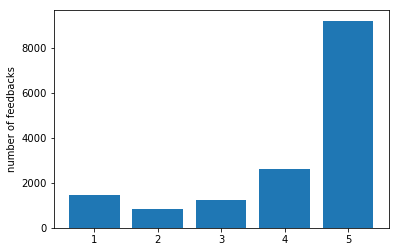

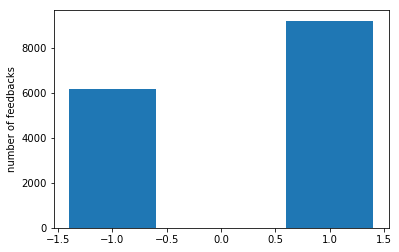

In [3]:
def arrangeBy(data, param):
    r_data = {}
    for row in data:
        r = row[param]
        if r in r_data:
            r_data[r].append(row)
        else:
            r_data[r] = []
    return collections.OrderedDict(sorted(r_data.items()))

def plotDist(data):
    ratings = list(data.keys())
    numbers = list(map(lambda x: len(x), data.values()))

    plt.bar(ratings,numbers)
    plt.ylabel('number of feedbacks')
    plt.show()

rows_all = list(map(lambda x: x[1], raw_data.iterrows()))
rows = []

for row in rows_all:
    isFive = -1
    if not row['reting'].is_integer():
        continue
    if row['reting'] == 5:
        isFive = 1
    row['isFive'] = isFive
    rows.append(row)
    
ratings_data_by_rating = arrangeBy(rows,'reting');
plotDist(ratings_data_by_rating)

ratings_data = arrangeBy(rows,'isFive');
plotDist(ratings_data)

normalize data

In [4]:
rows = list(ratings_data.values())

numbers = list(map(lambda x: len(x), rows))
feedbacks_per_rating = int(sum(numbers) - max(numbers))

print('five rates number:',max(numbers))
print('other rates number:',feedbacks_per_rating)

normal_rows = []

normal_rows = list(rows[0])
normal_rows.extend(list(rows[1]))
    
np.random.shuffle(normal_rows)
    
print('feedbacks number:',len(normal_rows))

five rates number: 9210
other rates number: 6175
feedbacks number: 15385


check the distribution of ratings

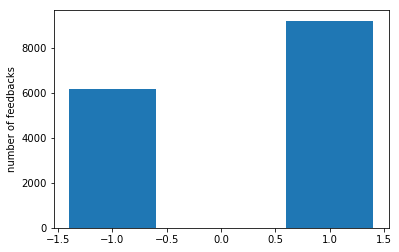

In [5]:
ratings_data = arrangeBy(normal_rows, 'isFive')
plotDist(ratings_data)

## Simple model

In [6]:
stop_words = stop_words = get_stop_words('ru')
count_vectorizer = CountVectorizer(min_df=0.0001, max_df=0.95, analyzer="word", stop_words=stop_words)

def evaluate_cross_validation(clf, X, y, K):
    cv = StratifiedKFold(K, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv) 
    print(scores)
    print("Mean score: {0:.3f} (+/-{1:.3f})".format(scores.mean(), scores.std()))
    
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
        
X = count_vectorizer.fit_transform((r['comment'] for r in normal_rows))
y = list(r['isFive'] for r in normal_rows)

frequent_words = dict(zip(count_vectorizer.get_feature_names(),np.asarray(X.sum(axis=0)).ravel()))
sorted_frequent_words = sorted(frequent_words.items(), key=operator.itemgetter(1))

print('the most frequent words', sorted_frequent_words[-20:])

clf = RandomForestClassifierWithCoef(n_estimators=512, min_samples_leaf=10, n_jobs=-1)
evaluate_cross_validation(clf, X, y, 6)

the most frequent words [('видео', 893), ('доволен', 914), ('купили', 921), ('купила', 945), ('цена', 954), ('довольна', 959), ('рекомендую', 999), ('модель', 1039), ('супер', 1045), ('хороший', 1053), ('звук', 1079), ('вообще', 1088), ('быстро', 1140), ('отличный', 1186), ('отлично', 1212), ('советую', 1312), ('пользуюсь', 1333), ('качество', 1358), ('купил', 1751), ('работает', 2097)]
[ 0.75633528  0.73400936  0.74921997  0.7425897   0.75156006  0.75312012]
Mean score: 0.748 (+/-0.007)


## Smarter model

morphological normalization, etc.

In [7]:
morph = pymorphy2.MorphAnalyzer()

regex_clear = re.compile('[^а-яё]',re.DOTALL)
regex_space = re.compile('\s{1,}',re.DOTALL)

def clear(text):
    tmp = re.sub(regex_clear, ' ', text.lower().replace('ё', 'е'))
    return re.sub(regex_space, ' ', tmp)

def prepare(text):
    return text.lower()

def to_normal(word):
    return morph.parse(word)[0].normal_form
    
def normalize(text):
    words = []
    for word in text.split(' '):
        words.append(to_normal(word))
    norm=' '.join(words)  
    return norm.replace('ё', 'е')

class TextNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        cleared = [clear(text) for text in texts]
        return [normalize(text) for text in texts]
    
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        return [prepare(text) for text in texts]

In [14]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('count_vectorizer', Pipeline([
                ('selector', TextCleaner()),
                ('cv', CountVectorizer(min_df=0.0001, max_df=0.95, ngram_range=(4,4), analyzer="char_wb")),
                #('best', TruncatedSVD(n_components=100)),
            ])),
            ('tfidf', Pipeline([
                 ('selector', TextCleaner()),
                 ('tfidf', TfidfVectorizer(analyzer="word", stop_words=stop_words)),
                 #('best', TruncatedSVD(n_components=10)), 
             ])),
            ('count_vectorizer_default', Pipeline([
                ('selector', TextNormalizer()),
                ('cv', CountVectorizer(min_df=0.0001, max_df=0.95, stop_words=stop_words, analyzer='word')),                                
            ])),

        ],
        transformer_weights={ 
            'count_vectorizer': 1,
            'tfidf': 1,
            'count_vectorizer_default': 1
       },
    )),

    #('model', SVC(kernel='linear')) #rbf, sigmoid, polynomial
    ('model', RandomForestClassifierWithCoef(n_estimators=512, min_samples_leaf=5, n_jobs=-1))
    
])

comments_x = list(r['comment'] for r in normal_rows)
ratings_y = list(r['isFive'] for r in normal_rows)

evaluate_cross_validation(pipeline, comments_x, ratings_y, 6)

[ 0.7785575   0.76365055  0.78081123  0.7800312   0.77418097  0.77574103]
Mean score: 0.775 (+/-0.006)


In [26]:
def to_dataframe(normal_rows):
    tmp_df = pd.DataFrame()
    tmp_df['comment'] = list(r['comment'] for r in normal_rows)
    tmp_df['isFive'] = list(r['isFive'] for r in normal_rows)
    return tmp_df

feedback_df = to_dataframe(normal_rows)
pipeline.fit(feedback_df['comment'], feedback_df['isFive'])

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('count_vectorizer', Pipeline(steps=[('selector', TextCleaner()), ('cv', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase...,
                oob_score=False, random_state=None, verbose=0,
                warm_start=False))])

In [32]:

X_train, X_test, y_train, y_test = train_test_split(feedback_df['comment'], feedback_df['isFive'], test_size = 0.33, random_state=42)
print(classification_report(pipeline.predict(X_test), y_test))

pickle.dump(pipeline, open('mvideo.feedback.pickle', 'wb'))

             precision    recall  f1-score   support

         -1       0.74      0.94      0.83      1603
          1       0.97      0.85      0.90      3475

avg / total       0.90      0.88      0.88      5078



In [53]:
result = pipeline.predict(["Отличная скороварка, просто прелесть что за агрегат!", 
                           "Сломался этот ваш телевизор на второй день",
                           "Так себе оказалась фритюрница, на троечку",
                           "Не советую брать этот смартфон, очень плохой звук"])
print(result)

[ 1 -1  1 -1]
